In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import mnist 

In [ ]:
tf.__version__

'2.3.0'

## Dataset -- MNIST

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)

x_train shape:  (60000, 28, 28)
x_test shape:  (10000, 28, 28)


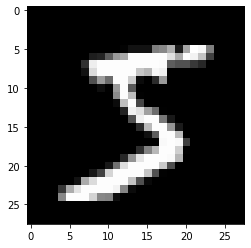

In [ ]:
plt.imshow(x_train[0], cmap="gray")
plt.show()

In [ ]:
y_train[0]

5

In [ ]:
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

y_train shape:  (60000,)
y_test shape:  (10000,)


In [ ]:
print(y_train[:10])

[5 0 4 1 9 2 1 3 1 4]


[0 1 2 3 4 5 6 7 8 9]
[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


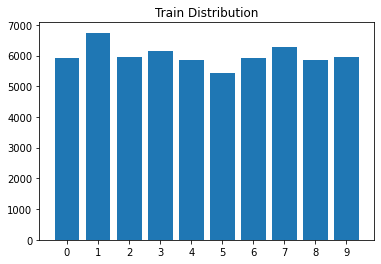

In [ ]:
label, counts = np.unique(y_train, return_counts=True)
print(label)
print(counts)

plt.bar(label, counts, tick_label=label)
plt.title("Train Distribution")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train,
                               test_size=0.2,
                               random_state=2,
                               stratify=y_train)

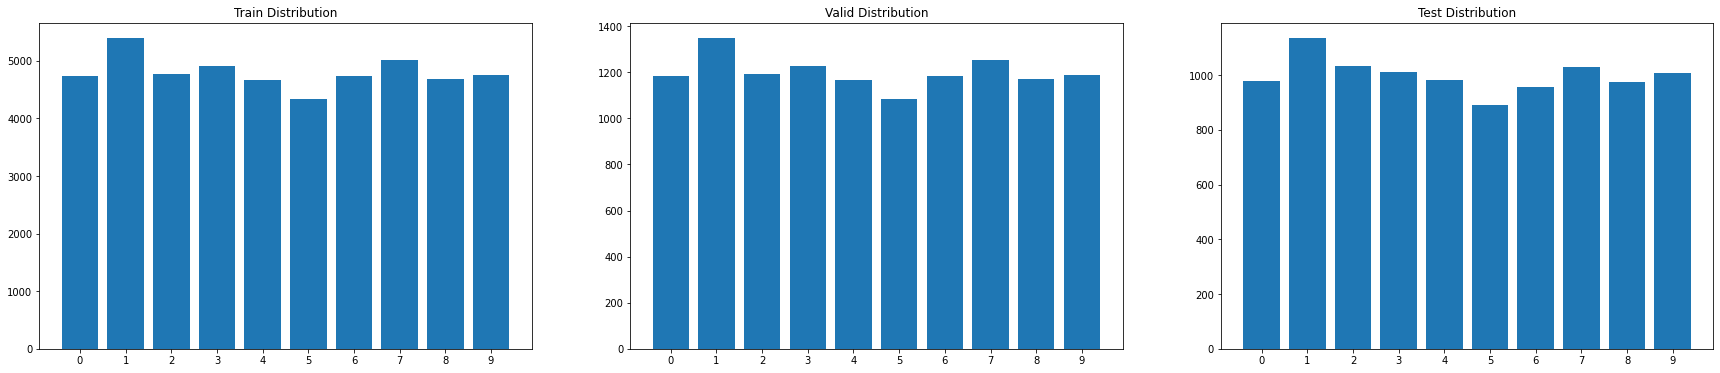

In [ ]:
data_list = [y_train, y_valid, y_test]
data_types = ["Train", "Valid", "Test"]

plt.figure(figsize=(30, 6))
for i in range(3):
  label, counts = np.unique(data_list[i], return_counts=True)

  plt.subplot(1, 3, i+1)
  plt.bar(label, counts, tick_label=label)
  plt.title(data_types[i]+" Distribution")
plt.show()

## Data Preprocessing

In [ ]:
print("x_train type: ", x_train.dtype)
print("x_train max: ", x_train.max())
print("x_train min: ", x_train.min())

x_train type:  uint8
x_train max:  255
x_train min:  0


#### min_max normalization

In [ ]:
x_train = x_train.astype("float32")/255
x_valid = x_valid.astype("float32")/255
x_test = x_test.astype("float32")/255

In [ ]:
print("x_train type: ", x_train.dtype)
print("x_train max: ", x_train.max())
print("x_train min: ", x_train.min())

x_train type:  float32
x_train max:  1.0
x_train min:  0.0


#### Reshape

In [ ]:
print("x_train shape: ", x_train.shape)

x_train shape:  (48000, 28, 28)


In [ ]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_valid = x_valid.reshape(x_valid.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

In [ ]:
print("x_train shape: ", x_train.shape)

x_train shape:  (48000, 784)


#### Category -- One-Hot Encoding

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
y_train_one = to_categorical(y_train)
y_valid_one = to_categorical(y_valid)
y_test_one = to_categorical(y_test)

In [ ]:
print("y_train type: ", y_train.dtype)
print("y_train shape: ", y_train.shape)
print("preprocessing".center(30, "-"))
print("y_train_one type: ", y_train_one.dtype)
print("y_train_one shape: ", y_train_one.shape)

y_train type:  uint8
y_train shape:  (48000,)
--------preprocessing---------
y_train_one type:  float32
y_train_one shape:  (48000, 10)


In [ ]:
y_train[:3]

array([6, 1, 3], dtype=uint8)

In [ ]:
y_train_one[:3]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## Modeling

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [ ]:
x_train[0].shape

(784,)

In [ ]:
num_classes = y_train_one[0].shape[0]
num_classes

10

In [ ]:
inputs = layers.Input(shape=x_train[0].shape)
x = layers.Dense(64, activation="relu")(inputs)

x = layers.Dense(16)(x)
x = layers.Activation("relu")(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)


model = Model(inputs=inputs, outputs=outputs)

In [ ]:
784*64+64

50240

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
activation (Activation)      (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 51,450
Trainable params: 51,450
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_weight = model.variables
# model_weight = model.get_weights()

In [ ]:
# model_weight

In [ ]:
# model_weight[0].shape

In [ ]:
from tensorflow.keras import callbacks

In [ ]:
model_dir = './model-logs'
if not os.path.exists(model_dir):
  os.makedirs(model_dir)


modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = callbacks.ModelCheckpoint(modelfiles,
                      monitor='val_accuracy',
                      save_best_only=True)

earlystop = callbacks.EarlyStopping(monitor='val_loss',
                    patience=3,
                    verbose=1)


callbacks_list = [model_mckp, earlystop]

In [ ]:
lr = 0.001
optimizer = optimizers.Adam(lr)
model.compile(loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

In [ ]:
num_epoch = 10
batch_size = 64
history = model.fit(x_train, y_train_one,
            batch_size=batch_size,
            epochs=num_epoch,
            validation_data=(x_valid, y_valid_one),
            )

Epoch 1/10
750/750 [==============================] - 3s 4ms/step - loss: 0.4090 - accuracy: 0.8848 - val_loss: 0.2105 - val_accuracy: 0.9403
Epoch 2/10
750/750 [==============================] - 2s 3ms/step - loss: 0.1815 - accuracy: 0.9478 - val_loss: 0.1808 - val_accuracy: 0.9451
Epoch 3/10
750/750 [==============================] - 2s 3ms/step - loss: 0.1377 - accuracy: 0.9600 - val_loss: 0.1535 - val_accuracy: 0.9553
Epoch 4/10
750/750 [==============================] - 3s 3ms/step - loss: 0.1084 - accuracy: 0.9677 - val_loss: 0.1246 - val_accuracy: 0.9632
Epoch 5/10
750/750 [==============================] - 2s 3ms/step - loss: 0.0903 - accuracy: 0.9731 - val_loss: 0.1141 - val_accuracy: 0.9649
Epoch 6/10
750/750 [==============================] - 3s 3ms/step - loss: 0.0744 - accuracy: 0.9779 - val_loss: 0.1052 - val_accuracy: 0.9678
Epoch 7/10
750/750 [==============================] - 3s 3ms/step - loss: 0.0637 - accuracy: 0.9805 - val_loss: 0.1082 - val_accuracy: 0.9678
Epoch 

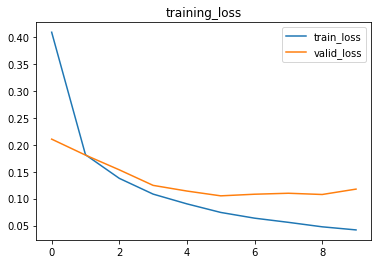

In [ ]:
plt.plot(np.arange(num_epoch), history.history['loss'], label="train_loss")
plt.plot(np.arange(num_epoch), history.history['val_loss'], label="valid_loss")
plt.legend(loc='best')
plt.title('training_loss')
plt.show()

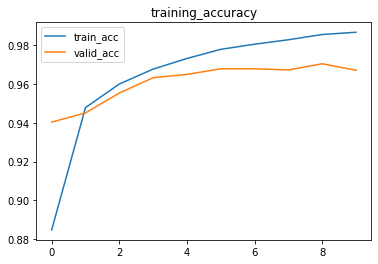

In [ ]:
plt.plot(np.arange(num_epoch), history.history['accuracy'], label="train_acc")
plt.plot(np.arange(num_epoch), history.history['val_accuracy'], label="valid_acc")
plt.legend(loc='best')
plt.title('training_accuracy')
plt.show()

In [ ]:
model.save("model_test.h5")

In [ ]:
model = load_model("model_test.h5")

## Prediction

In [ ]:
y_test_predprob = model.predict(x_test)
print(y_test_predprob[:3])

[[1.5840296e-08 5.9240246e-08 9.0714066e-06 2.4685818e-05 1.4496265e-10
  7.6523499e-08 1.4044533e-13 9.9996364e-01 5.4477357e-07 1.7942511e-06]
 [2.6994268e-11 7.8486858e-07 9.9991918e-01 7.9821068e-05 3.0350249e-18
  8.2970253e-08 3.5648159e-10 5.1265412e-11 4.2426397e-08 3.5305119e-16]
 [4.6236632e-08 9.9902821e-01 5.6357525e-04 2.7934391e-06 1.5259306e-05
  1.0097164e-06 2.9424091e-06 3.7282068e-04 1.3296666e-05 1.4845068e-08]]


In [ ]:
y_test_predprob.shape

(10000, 10)

In [ ]:
y_test_pred = y_test_predprob.argmax(-1)
print("y_test_pred shape: ", y_test_pred.shape)
print(y_test_pred[:3])

y_test_pred shape:  (10000,)
[7 2 1]


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
print(f"accuracy_score: {accuracy_score(y_test, y_test_pred):.3f}")
print("confusion matrix: \n", confusion_matrix(y_test, y_test_pred))

accuracy_score: 0.968
confusion matrix: 
 [[ 955    0    4    2    0    6    3    1    3    6]
 [   0 1123    4    1    0    2    3    1    1    0]
 [   2    2 1012    6    1    0    1    4    4    0]
 [   0    1    8  983    0    9    0    5    0    4]
 [   1    0    6    0  947    1    2    4    1   20]
 [   1    0    1   13    0  870    3    0    2    2]
 [   2    2    4    1    5   14  929    1    0    0]
 [   0    4   10    1    1    1    0 1000    3    8]
 [   0    1   10   34    3   15    4    8  879   20]
 [   2    2    1    9    6    3    0    5    0  981]]


In [ ]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


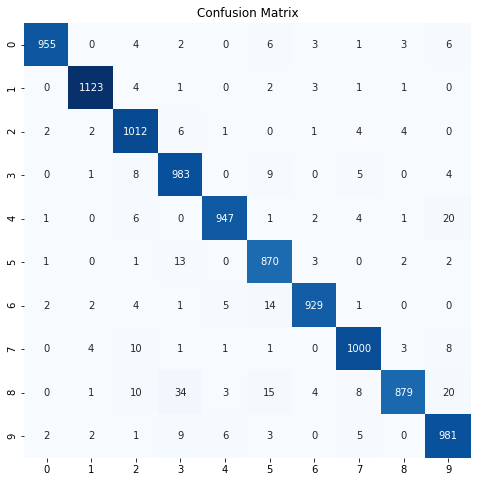

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_test, y_test_pred), 
      cmap="Blues", annot=True, fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.show()